# Plotting

---

Julia has several high quality registered plotting packages:

* [Winston.jl](https://github.com/nolta/Winston.jl) - simple but efficient 2D plots 
* [Gadfly.jl](https://github.com/dcjones/Gadfly.jl) - versatile 2D package with nice output
* [PyPlot.jl](https://github.com/stevengj/PyPlot.jl) - Julia interface to Python's Matplotlib - 2D, 3D, implicit, ...
* [Plots.jl](https://github.com/JuliaPlots/Plots.jl) - wrapper for several backends.

## Prerequisites

Browse the manuals (20 min):

* [Winston Documentation](http://winston.readthedocs.org/en/latest/)
* [Gadfly](http://gadflyjl.org/stable/)
* [The PyPlot module for Julia](https://github.com/stevengj/PyPlot.jl) and [Matplotlib](http://matplotlib.org/)
* [Intro to Plots in Julia](https://juliaplots.github.io/)


## Competences 

The reader should be able to use some of the features of the above packages. 

---

### Remark

Plotting packages are rather complex and depend on additional software, so it is advised to execute corresponding 
`Pkg.add()` commands in terminal mode.  

Also, plotting packges frequently use same (obvious) names for plot functions. When using more than one package in a Julia session, the functions need to be called by specifying the package, as well.

We shall ilustrate the packages on several numerical examples, which also give the flavor of Julia.

## Winston

We compute and plot:
* the natural cubic spline, as defined in [W. Cheney  and D. Kincaid, Numerical Mathematics and Computing, pp. 266-267][CK13], and 
* the standard interpolating polynomial. 

We shall use the registered package [SpecialMatrices.jl](https://github.com/jiahao/SpecialMatrices.jl).

[CK13]: https://books.google.hr/books?id=tDyYdqyZjSEC&pg=PA279&lpg=PA279&dq=kincaid+cheney+cubic+spline&source=bl&ots=3Y0f5tvQku&sig=fezZGlnQ7pR4E67TVkXEq_lF1Zc&hl=hr&sa=X&ved=0ahUKEwju8KGo7YjMAhXLVSwKHXyUAXEQ6AEIRzAG#v=onepage&q=kincaid%20cheney%20cubic%20spline&f=false "W. Cheney  and D. Kincaid, 'Numerical Mathematics and Computing', 7th Edition, Brooks/Cole, Boston, 2013"

In [1]:
# Pkg.add("SpecialMatrices"); Pkg.checkout("SpecialMatrices")
using Winston
using SpecialMatrices
using Polynomials

In [2]:
# Number of intervals
n=5
# n+1 points
t=[1.0,2,4,5,8,9]
y=[-1.0,1,4,0,2,6]
# Computation
h=t[2:end]-t[1:end-1]
b=(y[2:end]-y[1:end-1])./h
v=6*(b[2:end]-b[1:end-1])
H=SymTridiagonal(2*(h[1:end-1]+h[2:end]),h[2:end-1])

4×4 SymTridiagonal{Float64}:
 6.0  2.0   ⋅    ⋅ 
 2.0  6.0  1.0   ⋅ 
  ⋅   1.0  8.0  3.0
  ⋅    ⋅   3.0  8.0

In [3]:
z=H\v
z=[0;z;0]

6-element Array{Float64,1}:
  0.0    
  1.74766
 -6.74299
  3.96262
  1.01402
  0.0    

In [4]:
# Define the splines
B=b-(z[2:end]-z[1:end-1]).*h/6
S=Array{Any}(n)
S=[x-> y[i]-z[i]*h[i]^2/6+B[i]*(x-t[i])+z[i]*(t[i+1]-x)^3/
    (6*h[i])+z[i+1]*(x-t[i])^3/(6*h[i]) for i=1:n]

5-element Array{##2#4{Int64},1}:
 #2
 #2
 #2
 #2
 #2

In [5]:
# Define the points to plot
lsize=200
x=linspace(t[1],t[end],lsize)
zSpline=Array{Float64}(lsize)
for i=1:lsize
    for k=1:n
        if x[i]<=t[k+1]
            zSpline[i]=S[k](x[i])
            break
        end
    end
end

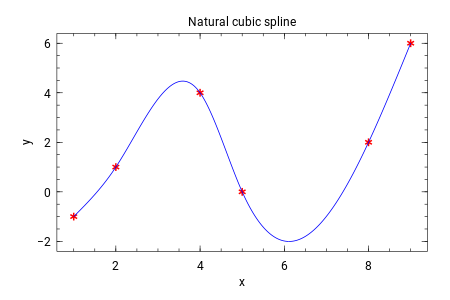

In [6]:
# Plot
Winston.plot(t,y,"r*",x,zSpline,"b")
Winston.title("Natural cubic spline")
Winston.xlabel("x")
Winston.ylabel("y")

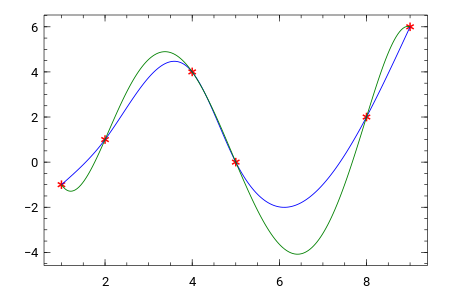

In [7]:
# Standard interpolating polynomial
A=Vandermonde(t)
p=Poly(full(A)\y)
yPoly=p(x)
Winston.plot(t,y,"r*",x,zSpline,"b",x,yPoly,"g")

## Gadfly

We shall illustrate Gadfly with two examples:
* function and its derivative, and
* exact solution of an initial value problem v.s. the solution computed with our implementation of the Euler's method.

N.B. Gadfly plots can be nicely zoomed in or out. Variety of ODE solvers can be found in the package  [ODE.jl](https://github.com/JuliaLang/ODE.jl)

### Function and its derivative

Derivative of a function can be:
* approximated by finite differences using the package [Calculus.jl](https://github.com/johnmyleswhite/Calculus.jl),
* approximated by [automatic differentiation
(https://en.wikipedia.org/wiki/Automatic_differentiation) using the package
[ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl) which is fast, 
more accurate, and is our method of choice (see the [Documentation](http://www.juliadiff.org/ForwardDiff.jl/perf_diff.html#derivatives)), and 
* computed symbolicaly using the package [SymPy.jl](https://github.com/jverzani/SymPy.jl).

In [8]:
# Pkg.add("ForwardDiff")
using ForwardDiff
using Gadfly

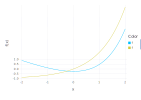

In [9]:
f(x)=exp(x)-x-5.0/4
Gadfly.plot([f,x->ForwardDiff.derivative(f,x)],-2.0,2.0,
    Guide.yticks(ticks=[-1.0,-0.5,0.0,0.5,1.0]))

### Solution of an  initial value problem

The exact solution of the initial value problem 
$$
y'=x+y,\quad y(0)=1,
$$

is

$$
y=2e^x-x-1.
$$


In [10]:
# Euler's method
function myEuler{T,T1}(f::Function,y0::T,x::T1)
    h=x[2]-x[1]
    y=Array{T}(length(x))
    y[1]=y0
    for i=2:length(x)
        y[i]=y[i-1]+h*f(x[i-1],y[i-1])
    end
    y
end

myEuler (generic function with 1 method)

In [11]:
# n subintervals on the interval [0,1]
n=30
x=linspace(0,1,n+1)
f1(x,y)=x+y
y=myEuler(f1,1.0,x)

31-element Array{Float64,1}:
 1.0    
 1.03333
 1.06889
 1.10674
 1.14697
 1.18964
 1.23485
 1.28268
 1.33321
 1.38654
 1.44276
 1.50197
 1.56425
 ⋮      
 2.09572
 2.18669
 2.2818 
 2.38119
 2.48501
 2.5934 
 2.70651
 2.82451
 2.94755
 3.0758 
 3.20943
 3.34864

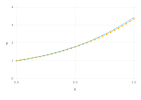

In [12]:
# We can plot functions and data sets (points) using layers
solution(x)=2*exp(x)-x-1
Gadfly.plot(layer(solution,0,1),
layer(x=x,y=y,Geom.point, Geom.line, 
        Theme(default_color=colorant"orange")))

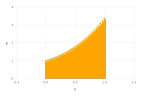

In [13]:
# Or, with a different geometry
Gadfly.plot(layer(solution,0,1),
layer(x=x,y=y,Geom.point, Geom.bar, 
        Theme(default_color=colorant"orange")))

## PyPlot

We shall illustrate PyPlot with two examples:
* 3D and contour plots to graphically solve small system of non-linear equations, and
* implicit plot of the solution of Lotka-Volterra equations in the phase-space. 

### System of non-linear equations

The solutions of the system

\begin{align*}
2(x_1+x_2)^2-(x_1-x_2)^2&=8\\
5x_1^2+(x_2-3)^2&=9
\end{align*}

are

\begin{align*}
S_1&=(-1.183467003241957,1.5868371427229244),\\ S_2&=(1,1).
\end{align*}

Let us plot the surfaces. We shall use the function `meshgrid()` from 
https://fossies.org/linux/julia/examples/ndgrid.jl.

In [14]:
using PyPlot

In [15]:
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
   m, n = length(vy), length(vx)
   vx = reshape(vx, 1, n)
   vy = reshape(vy, m, 1)
   (repmat(vx, m, 1), repmat(vy, 1, n))
end

meshgrid (generic function with 1 method)

In [16]:
# Define the system
f(x,y)=[2(x+y).^2+(x-y).^2-8,5*x.^2+(y-3).^2-9]

f (generic function with 2 methods)

In [17]:
# Prepare the mexhgrid manually
gridsize=100
X=linspace(-2,3,gridsize)
Y=linspace(-2,2,gridsize)
U=meshgrid(X,Y)
Z=f(U[1],U[2])

2-element Array{Array{Float64,2},1}:
 [24.0 23.1996 … 18.3006 19.0; 23.3584 22.5621 … 18.059 18.7625; … ; 7.68167 7.2812 … 41.1782 42.2776; 8.0 7.60361 … 41.8965 43.0] 
 [36.0 35.0027 … 59.4976 61.0; 35.5976 34.6002 … 59.0952 60.5976; … ; 12.0824 11.0851 … 35.58 37.0824; 12.0 11.0027 … 35.4976 37.0]

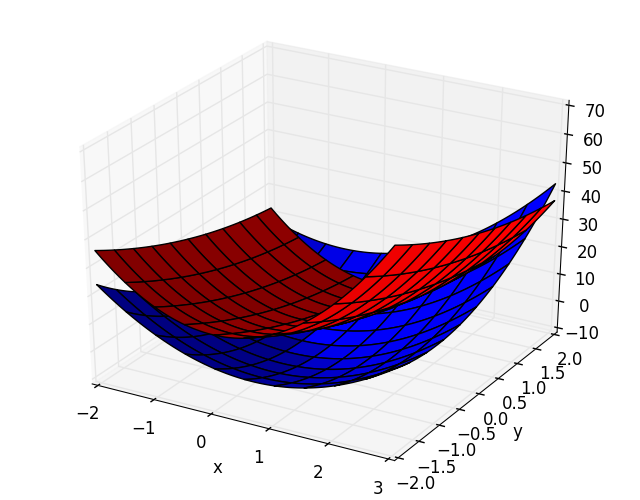

PyObject <matplotlib.text.Text object at 0x7fef6ae75fd0>

In [18]:
# Plot
PyPlot.surf(U[1],U[2],Z[1])
PyPlot.surf(U[1],U[2],Z[2],color="red")
PyPlot.xlabel("x")
PyPlot.ylabel("y")

Let us plot the contours at $z=0$:

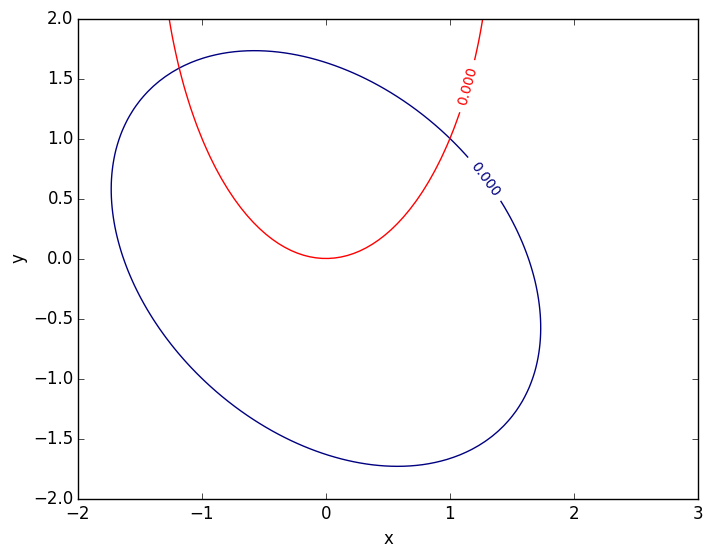

PyObject <matplotlib.text.Text object at 0x7fef6ad17850>

In [19]:
C1=contour(U[1],U[2],Z[1],levels=[0])
C2=contour(U[1],U[2],Z[2],levels=[0],colors="red")
clabel(C1,inline=1, fontsize=10)
clabel(C2,inline=1, fontsize=10)
PyPlot.xlabel("x")
PyPlot.ylabel("y")

### Plotting implicit functions

The phase-space solution of the Lotka-Volterra system of equations in dimensionless variables in scaled time 
has the form 

$$
yx^\sigma=Ce^ye^{x\sigma}.
$$

For implicit plots, we also need the package `SymPy.jl`. Plotting takes a little longer.

In [20]:
using SymPy

In [21]:
# Define the parameters
C=0.25
σ=1/3
# Define symbolic variables
@vars x y

(x, y)

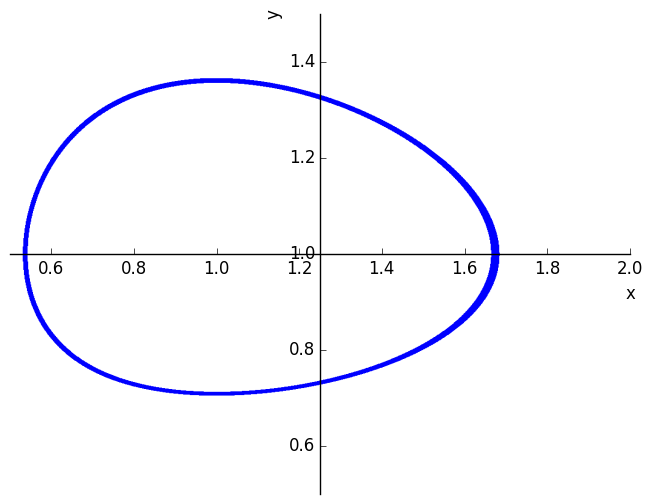

PyObject <sympy.plotting.plot.Plot object at 0x7fef698ba310>

In [22]:
SymPy.plot_implicit(Eq(y*x^σ,C*exp(y+σ*x)),(x,0.5,2),(y,0.5,1.5))